# Measure Capacity of QNN architechture with Effective Dimension analysis

References:
- QISKIT guide to calculate ED: [Effective Dimension of Qiskit Neural Networks](https://qiskit.org/documentation/machine-learning/tutorials/10_effective_dimension.html)
- [The power of quantum neural networks](https://arxiv.org/pdf/2011.00027.pdf)
- [Effective dimension of machine learning models](https://arxiv.org/pdf/2112.04807.pdf)

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.23.1', 'qiskit-aer': '0.11.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.0', 'qiskit': '0.41.0', 'qiskit-nature': '0.5.2', 'qiskit-finance': '0.3.4', 'qiskit-optimization': '0.5.0', 'qiskit-machine-learning': '0.5.0'}

The Fisher Information matrix reflects how sensitive a neural network's output to change in the network's parameter space.
Effective dimension uses Fisher Information matrix to measure capacity of NNs.

Steps as follows:
- Define a neural network
- Define a series of inputs and weight samples.
- Use `EffectiveDimension` class to calculate effective dimension


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, NELDER_MEAD, SLSQP, SPSA
from qiskit.opflow import Z, X, I, StateFn, PauliExpectation, Gradient, PauliSumOp
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN, OpflowQNN
from qiskit_machine_learning.neural_networks import EffectiveDimension
from qiskit_machine_learning.algorithms.classifiers import VQC, NeuralNetworkClassifier
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension

from Components.circuits import preTrainedBlockGenerator, layerwise_training, featureMapGenerator, AnsatzGenerator
from Components.data import iris, fetch_mnist_balanced
from Components.utils import plot_loss, score, parity, classification_callback, plot_objfn_range, result_to_objfun_dataframes, save_results
from Components.train import create_qnn, sampling_experiment

from qiskit.providers.fake_provider import FakeVigo, FakePerth

import pandas as pd

import time

from IPython.display import clear_output

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

try state vector

In [3]:
backend = Aer.get_backend('statevector_simulator')

q_instance = QuantumInstance(
    backend, 
    shots = 100, 
    seed_simulator = 2718, 
    seed_transpiler = 2718,
    )

## Settings for experiment

In [4]:
DATA_SIZE = 500
FEATURE_DIM = 4
MAX_ITER = 120
MAX_INST = 10

MAX_REPS = 9
MIN_REPS = 3
MAX_IDENTITIES_BLOCKS = 2
ENTANGLEMENT = 'linear'

GLOBAL_INPUT_SAMPLES = 20
GLOBAL_WEIGHT_SAMPLES = 20

GLOBAL_OPERATOR = PauliSumOp.from_list([('Z'*FEATURE_DIM, 1)])
LOCAL_OPERATOR = PauliSumOp.from_list([('I' * (FEATURE_DIM - 2)+'Z'*2, 1)])

# define ranges to test different numbers of data
n = [75, 90, 105, 120, 135, 150, 200, 300, 400, 1000, 5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

# use user defined data
# iris_df = iris(pd=True).drop(columns='target')
mnist_df = fetch_mnist_balanced(PCA_n = FEATURE_DIM, data_size=100, split=False)[0]
# input_samples = iris_df.to_numpy()

### Select a data set and its folder
SAVE_PATH = './Saves-MNIST-500-v3'
input_samples= mnist_df

# trained weights
Weights_0 = [pd.read_csv(f'{SAVE_PATH}/Weights/m0/sample_{i}.csv', index_col=[0]) for i in range(10)]
Weights_1 = [pd.read_csv(f'{SAVE_PATH}/Weights/m1/sample_{i}.csv', index_col=[0]) for i in range(10)]
Weights_2 = [pd.read_csv(f'{SAVE_PATH}/Weights/m2/sample_{i}.csv', index_col=[0]) for i in range(10)]
Weights_3 = [pd.read_csv(f'{SAVE_PATH}/Weights/m3/sample_{i}.csv', index_col=[0]) for i in range(10)]

/home/jacob/miniconda3/envs/qiskit/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Data set: 100 samples
No train/test splitting
Number of features: 785
Classes: [-1  1]


In [5]:
# Global effective dimension
def get_global_ed(qnn):
    # weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

    global_ed = EffectiveDimension(
        qnn=qnn, 
        weight_samples=GLOBAL_WEIGHT_SAMPLES, 
        input_samples=GLOBAL_INPUT_SAMPLES
        )
        
    return global_ed

def get_local_ed_loop(qnn, weight_samples, input_samples, dataset_size, step_size=25):
    local_ed_list = []
    for i in range(0, len(weight_samples), step_size):
        local_ed = LocalEffectiveDimension(
            qnn=qnn, 
            weight_samples=weight_samples.iloc[i], 
            input_samples=input_samples
        )
        local_eff_dim = local_ed.get_effective_dimension(dataset_size=dataset_size)
        local_ed_list.append(local_eff_dim)
        print(f'Iteration: {i}; Local E-D: {local_eff_dim}\n')

    return local_ed_list

# This function is not needed as all variants should return the same values
def get_global_ed_loop(qnn, weight_samples, input_samples, dataset_size, step_size=25):
    global_ed_list = []
    
    for i in range(0, len(weight_samples), step_size):
        global_ed = EffectiveDimension(
            qnn=qnn, 
            weight_samples=weight_samples, 
            input_samples=input_samples
        )
        global_eff_dim = global_ed.get_effective_dimension(dataset_size=dataset_size)
        global_ed_list.append(global_eff_dim)
        print(f'Iteration: {i}; Local E-D: {global_eff_dim}\n')
        
    return global_ed_list

## Method 0 Effective Dim (Generic - No BP Strategy)

In [ ]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz_method_0 = AnsatzGenerator(FEATURE_DIM, reps=MAX_REPS)
circuit_0 = feature_map.compose(ansatz_method_0)

qnn_0 = EstimatorQNN(
    circuit=circuit_0,
    observables=SparsePauliOp.from_operator(GLOBAL_OPERATOR),
    input_params=list(feature_map.parameters),
    weight_params=list(ansatz_method_0.parameters),
)

### Global

In [ ]:
global_ed_0 = get_global_ed(qnn=qnn_0)
global_eff_0 = global_ed_0.get_effective_dimension(dataset_size=n)

In [ ]:
# plot the normalized effective dimension for the model
d_0 = qnn_0.num_weights
plt.plot(n, np.array(global_eff_0) / d_0)
plt.title("Normalized GLOBAL effective dimension - "+"Method 0")
plt.semilogx()
plt.xlabel("Number of data")
plt.ylabel("Effective dimension")
plt.show()

### Local

In [ ]:
local_eff_0 = []

for i in range(len(Weights_0)):
    print(f'Weight sample {len(local_eff_0)}')
    l_e = get_local_ed_loop(qnn_0, Weights_0[i], input_samples, n)
    local_eff_0.append(l_e)
    clear_output(wait=True)
    

In [ ]:
for i in range(len(local_eff_0[0])):
    plt.plot(n, np.array(local_eff_0[0][i]) / qnn_0.num_weights, label=f"iteration {i*25}")

plt.title(f'Method 0, d={Weights_0[0].shape[1]}')
plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.legend()
plt.plot()
plt.semilogx()

## Method 1 Effective Dim (Local Cost Function and Shallow Depth)

In [ ]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz_method_1 = AnsatzGenerator(FEATURE_DIM, reps=1)
circuit_1 = feature_map.compose(ansatz_method_1)

qnn_1 = EstimatorQNN(
    circuit = circuit_1,
    observables=SparsePauliOp.from_operator(LOCAL_OPERATOR),
    input_params=list(feature_map.parameters),
    weight_params=list(ansatz_method_1.parameters),
)

### Global

In [ ]:
global_ed_1 = get_global_ed(qnn=qnn_1)
global_eff_1 = global_ed_1.get_effective_dimension(dataset_size=n)

In [ ]:
# plot the normalized effective dimension for the model
d_1 = qnn_1.num_weights
plt.plot(n, np.array(global_eff_1) / d_1)
plt.title("Normalized GLOBAL effective dimension - "+"Method 1")
plt.semilogx()
plt.xlabel("Number of data")
plt.ylabel("Effective dimension")
plt.show()

### Local

In [ ]:
local_eff_1 = []

for i in range(len(Weights_1)):
    print(f'Weight sample {len(local_eff_1)}')
    l_e = get_local_ed_loop(qnn_1, Weights_1[i], input_samples, n)
    local_eff_1.append(l_e)
    clear_output(wait=True)

In [ ]:
for i in range(len(local_eff_1[0])):
    plt.plot(n, np.array(local_eff_1[0][i]) / qnn_1.num_weights, label=f"iteration {i*25}")

plt.title(f'Method 1, d={Weights_1[0].shape[1]}')
plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.legend()
plt.plot()
plt.semilogx()

## Method 2 Effective Dim (Layerwise Learning)

In [ ]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz_method_2 = AnsatzGenerator(FEATURE_DIM, reps=MAX_REPS)
circuit_2 = feature_map.compose(ansatz_method_2)

optimizer = COBYLA(maxiter=50)

qnn_2 = SamplerQNN(
    circuit = circuit_2,
    input_params=list(feature_map.parameters),
    weight_params=list(ansatz_method_2.parameters),
    sparse=False
)

### Global

In [ ]:
global_ed_2 = get_global_ed(qnn=qnn_2)
global_eff_2 = global_ed_2.get_effective_dimension(dataset_size=n)

In [ ]:
# plot the normalized effective dimension for the model
d_2 = qnn_2.num_weights
plt.plot(n, np.array(global_eff_2) / d_2)
plt.title("Normalized GLOBAL effective dimension - "+"Method 2")
plt.semilogx()
plt.xlabel("Number of data")
plt.ylabel("Effective dimension")
plt.show()

### Local

In [ ]:
local_eff_2 = []

for i in range(len(Weights_2)):
    print(f'Weight sample {len(local_eff_2)}')
    l_e = get_local_ed_loop(qnn_2, Weights_2[i], input_samples, n)
    local_eff_2.append(l_e)
    clear_output(wait=True)

In [ ]:
for i in range(len(local_eff_2[0])):
    plt.plot(n, np.array(local_eff_2[0][i]) / qnn_2.num_weights, label=f"iteration {i*25}")

plt.title(f'Method 2, d={Weights_2[0].shape[1]}')
plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.legend()
plt.plot()
plt.semilogx()

## Method 3 Effective Dim (Identity Blocks)

In [6]:
from qiskit.primitives import Estimator # Statevector estimator

In [7]:
feature_map = featureMapGenerator(FEATURE_DIM)
# identity_block = preTrainedBlockGenerator(max_qubit, MAX_IDENTITIES_BLOCKS)
identity_block = preTrainedBlockGenerator(FEATURE_DIM, MAX_IDENTITIES_BLOCKS, overlay=2, entanglement=ENTANGLEMENT, insert_barriers=True)
ansatz_method_3 = identity_block['circuit']
circuit_3 = feature_map.compose(ansatz_method_3)

# qnn_3 = SamplerQNN(
#     circuit = circuit_3,
#     input_params=list(feature_map.parameters),
#     weight_params=list(ansatz_method_3.parameters),
#     sparse=False
# )

qnn_3 = EstimatorQNN(
    circuit=circuit_3,
    estimator=Estimator(),
    observables=GLOBAL_OPERATOR,
    input_params=feature_map.parameters,
    weight_params=ansatz_method_3.parameters
)


### Global

In [8]:
global_ed_3 = get_global_ed(qnn=qnn_3)
global_eff_3 = global_ed_3.get_effective_dimension(dataset_size=n)

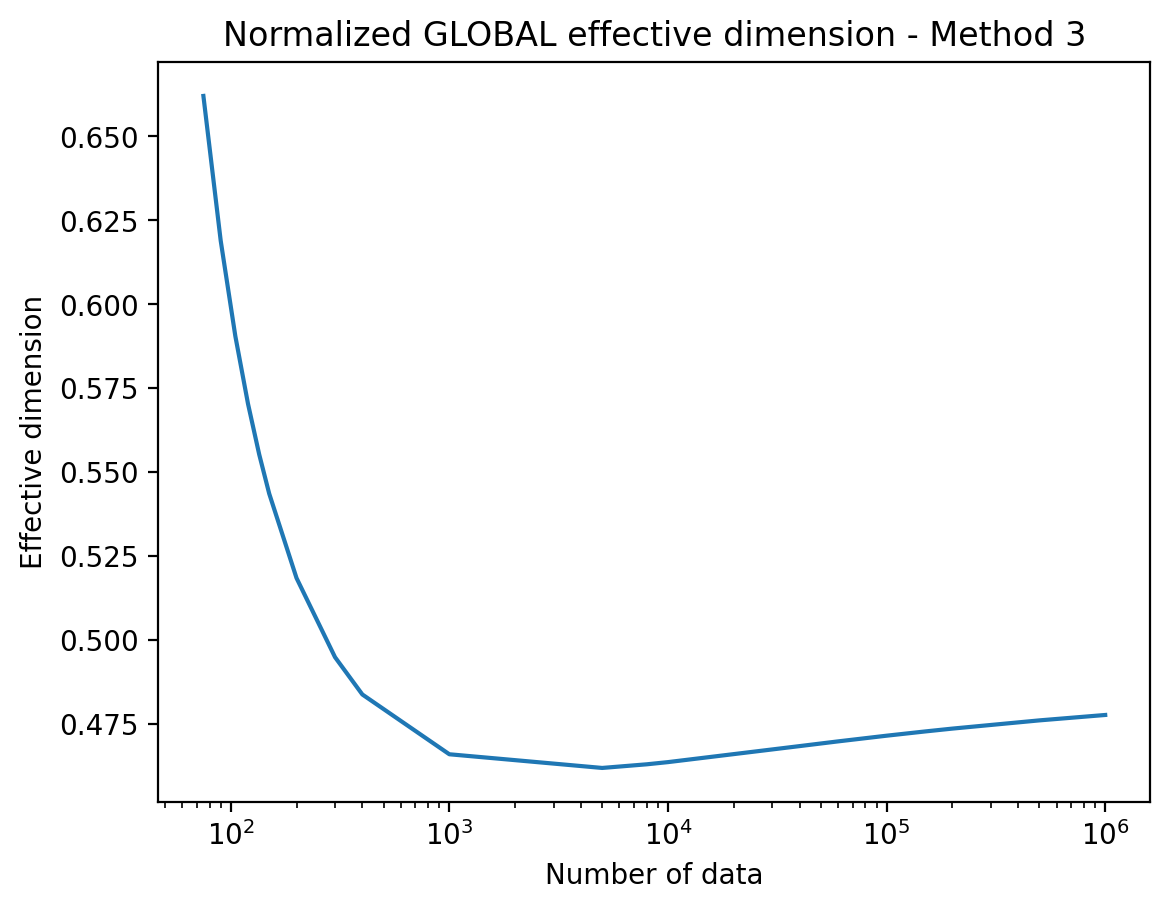

In [9]:
# plot the normalized effective dimension for the model
d_3 = qnn_3.num_weights
plt.plot(n, np.array(global_eff_3) / d_3)
plt.title("Normalized GLOBAL effective dimension - "+"Method 3")
plt.semilogx()
plt.xlabel("Number of data")
plt.ylabel("Effective dimension")
plt.show()

### Local

In [10]:
local_eff_3 = []
for i in range(len(Weights_3)):
    print(f'Weight sample {len(local_eff_3)}')
    l_e = get_local_ed_loop(qnn_3, Weights_3[i], input_samples, n)
    local_eff_3.append(l_e)
    clear_output(wait=True)

Weight sample 9
Iteration: 0; Local E-D: [24.73954939 23.03342698 21.89587276 21.07901248 20.46145214 19.97657112
 18.90588414 17.83950033 17.29174501 16.20421581 15.37880827 15.24903893
 15.19706711 14.9697737  14.92663484 14.88411117 14.85884101 14.84503102
 14.82007126 14.8153262 ]

Iteration: 25; Local E-D: [31.5827477  29.60365127 28.30070361 27.37677443 26.68689742 26.15183236
 24.99834656 23.90905257 23.38812167 22.50962448 22.18145192 22.18921944
 22.19913207 22.29656764 22.3277138  22.3655124  22.39389453 22.41307021
 22.46894645 22.50669654]

Iteration: 50; Local E-D: [31.36844778 29.40124216 28.10623439 27.18806577 26.50262194 25.97112145
 24.82601423 23.74664156 23.23219061 22.37383527 22.07821676 22.09384157
 22.1071778  22.22189097 22.25698872 22.29919421 22.33066848 22.35183788
 22.41302626 22.4537385 ]

Iteration: 75; Local E-D: [31.40301545 29.43428633 28.13805957 27.21883585 26.53244    26.00006079
 24.8523884  23.76899096 23.25149886 22.38413775 22.08405888 22.102173

[]

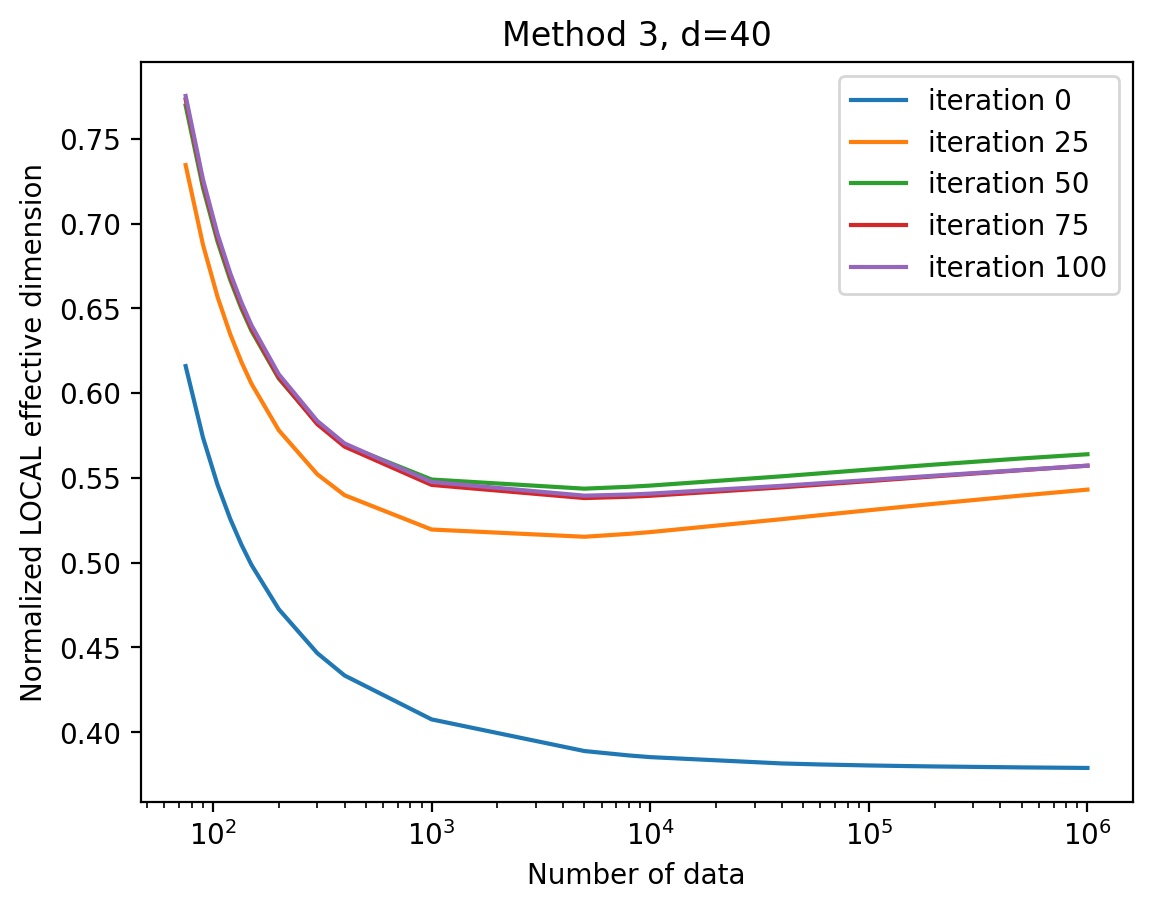

In [11]:
for i in range(len(local_eff_3[0])):
    plt.plot(n, np.array(local_eff_3[0][i]) / qnn_3.num_weights, label=f"iteration {i*25}")

plt.title(f'Method 3, d={Weights_3[0].shape[1]}')
plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.legend()
plt.plot()
plt.semilogx()

### Save Scripts

In [12]:
l_eff = [0, 1, 2, local_eff_3]
i = 3
for l in range(len(l_eff[i])):
    df = pd.DataFrame(l_eff[i][l])
    df.to_csv(f'{SAVE_PATH}/LocalED/m{i}/sample_{l}.csv')

In [13]:
# l_eff = [local_eff_0, local_eff_1, local_eff_2, local_eff_3]
# for i in range(len(l_eff)):
#     for l in range(len(l_eff[i])):
#         df = pd.DataFrame(l_eff[i][l])
#         df.to_csv(f'{SAVE_PATH}/LocalED/m{i}/sample_{l}.csv')

In [14]:
g_eff = [0, 1, 2, global_eff_3]
i = 3
df = pd.DataFrame(g_eff[i])
df.to_csv(f'{SAVE_PATH}/GlobalED/m{i}/sample.csv')

In [15]:
# g_eff = [global_eff_0, global_eff_1, global_eff_2, global_eff_3]
# for i in range(len(g_eff)):
#     df = pd.DataFrame(g_eff[i])
#     df.to_csv(f'{SAVE_PATH}/GlobalED/m{i}/sample.csv')

## Results Global

We expect the model with more capacity would reflect to the line that stays on top.
See Section 4.2 of [The power of quantum neural networks](https://arxiv.org/pdf/2011.00027v1.pdf)

Expect the local effective dimension would decrease after training.
It is because of the model has adapted to solving a specific problem, while the goal of the machine learning is to pick a model that is expressive enough to train.
However this piece of information is out of scope, because our goal is to measure the capacity (expressiveness) of models, not to discover how the training affect the model expressiveness.

In [ ]:
plt.title('GLOBAL Effective Dimension (Normalized)')
plt.plot(n, np.array(global_eff_0) / qnn_0.num_weights, label = 'method 0')
plt.plot(n, np.array(global_eff_1) / qnn_1.num_weights, label = 'method 1')
plt.plot(n, np.array(global_eff_2) / qnn_2.num_weights, label = 'method 2')
plt.plot(n, np.array(global_eff_3) / qnn_3.num_weights, label = 'method 3')
plt.xlabel("Number of data")
plt.ylabel("Normalized GLOBAL effective dimension")
plt.legend(loc='best')
plt.plot()
plt.semilogx()

In [ ]:
plt.title('GLOBAL Effective Dimension (Raw)')
plt.plot(n, np.array(global_eff_0), label = 'method 0')
plt.plot(n, np.array(global_eff_1), label = 'method 1')
plt.plot(n, np.array(global_eff_2), label = 'method 2')
plt.plot(n, np.array(global_eff_3), label = 'method 3')
plt.xlabel("Number of data")
plt.ylabel("GLOBAL effective dimension")
plt.legend(loc='best')
plt.plot()
plt.semilogx()